In [1]:
import numpy as np
import torch
import scipy
import matplotlib.pyplot as plt
import sklearn.decomposition
from sklearn import svm
from collections import defaultdict
from collections import Counter
from matplotlib import rcParams
import matplotlib.patches as mpatches
import seaborn
import os

seaborn.set(font='Arial')
plt.style.use('default')
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 11
rcParams['pdf.fonttype'] = 42
plt.rcParams.update({"text.color": 'k'})

import sys
sys.path.append('./')
import auxiliary_bed_functions as abf

date = '7_21_20' # Change this to today's date for output names.

input_dir = '../ATACseq_pileup/' # directory where the HOSVD files can be found
file_prefix = 'leiomyoma_HOSVD_final' # prefix used for input files
output_dir = '../' # directory to write output

In [2]:
def read_pileup(pileup_file, peak_file):
    peak_regions = abf.sortBedFirstCoord(abf.readBed(peak_file))
    peak_flat_regions = []
    for c in range(len(peak_regions)):
        for i in range(len(peak_regions[c])):
            peak_flat_regions.append(peak_regions[c][i])
    
    pileup_dict = {}
    f = open(pileup_file, 'r')
    for line in f:
        l = line.strip().split('\t')
        pileup_dict[(l[0], int(l[1]))] = int(l[3])
    f.close()    
        
    ATAC_pileup = [[0 for i in range(1001)] for j in range(len(peak_flat_regions))]
    
    for p in range(len(peak_flat_regions)):
        chrom = peak_flat_regions[p][0]
        start = peak_flat_regions[p][1]
        end   = peak_flat_regions[p][2]
        for i in range(start,end):
            ATAC_pileup[p][i-start] = pileup_dict[(chrom, i+1)]
    
    return np.array(ATAC_pileup)

In [3]:
pt_list = ['pt3', 'pt4', 'pt5', 'pt6',
           'pt7', 'pt8', 'pt11', 'pt12']

L_pt_scale = [(10**7/35065947), (10**7/28215847), (10**7/40058892), (10**7/35634626),
              (10**7/41532605), (10**7/40044119), (10**7/73230253), (10**7/43656754)]

pt_L_L_ATAC_pileup = [[] for pt in pt_list]

for i, pt in enumerate(pt_list):

    pt_L_L_ATAC_pileup[i] = read_pileup(input_dir + 'L_'+pt+'_ATACseq_leio_all_summits_1kb_pileup.txt',
                                        input_dir + 'AllATAC_summits_1kbregions_leio_all.bed')
    
    pt_L_L_ATAC_pileup[i] = L_pt_scale[i]*pt_L_L_ATAC_pileup[i]
    
print(np.array(pt_L_L_ATAC_pileup).shape)

(8, 4089, 1001)


In [4]:
L_L_ATAC_pileup = np.median(pt_L_L_ATAC_pileup, axis = 0)
L_L_ATAC_pileup_norm = np.copy(np.array(L_L_ATAC_pileup, dtype=np.float64))
        
L_L_ATAC_pileup_mean = np.mean(L_L_ATAC_pileup_norm, axis=0)

In [5]:
pt_list = ['pt3', 'pt4', 'pt5', 'pt6',
           'pt7', 'pt8', 'pt11', 'pt12']

M_pt_scale = [(10**7/37973403), (10**7/36344980), (10**7/30421051), (10**7/33270014),
              (10**7/39632577), (10**7/46943549), (10**7/43894953), (10**7/35456660)]

pt_M_L_ATAC_pileup = [[] for pt in pt_list]

for i, pt in enumerate(pt_list):
    pt_M_L_ATAC_pileup[i] = read_pileup(input_dir + 'M_'+pt+'_ATACseq_leio_all_summits_1kb_pileup.txt',
                                        input_dir + 'AllATAC_summits_1kbregions_leio_all.bed')

    pt_M_L_ATAC_pileup[i] = M_pt_scale[i]*pt_M_L_ATAC_pileup[i]
    
print(np.array(pt_M_L_ATAC_pileup).shape)

(8, 4089, 1001)


In [6]:
M_L_ATAC_pileup = np.median(pt_M_L_ATAC_pileup, axis = 0)
M_L_ATAC_pileup_norm = np.copy(np.array(M_L_ATAC_pileup, dtype=np.float64))
        
M_L_ATAC_pileup_mean = np.mean(M_L_ATAC_pileup_norm, axis=0)

Text(0.5, 1.0, 'Mean ATAC-seq signal around peak summits in\nregions with higher histone modifications in leiomyoma')

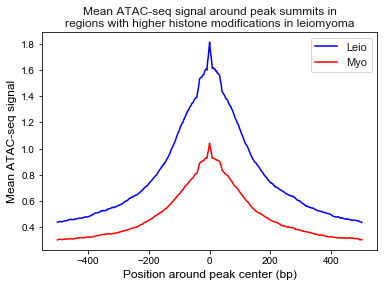

In [7]:
l1, = plt.plot([i for i in range(-500,501)], L_L_ATAC_pileup_mean, c=(0,0,1,1))
l2, = plt.plot([i for i in range(-500,501)], M_L_ATAC_pileup_mean, c=(1,0,0,1))
plt.legend([l1, l2], ["Leio", "Myo"], fontsize=11)

plt.ylabel('Mean ATAC-seq signal', fontsize=12)
plt.xlabel('Position around peak center (bp)', fontsize=12)

plt.title('Mean ATAC-seq signal around peak summits in\nregions with higher histone modifications in leiomyoma', fontsize=12)

In [8]:
print(L_L_ATAC_pileup_mean[0], L_L_ATAC_pileup_mean[-1])
print(M_L_ATAC_pileup_mean[0], M_L_ATAC_pileup_mean[-1])

0.43651981096431736 0.4351409595177333
0.30187085412569437 0.30331429181429803


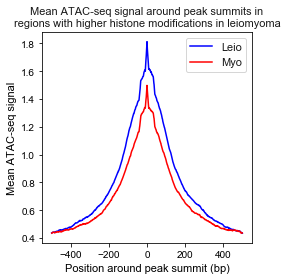

In [9]:
# Figure S7A
fig = plt.figure(figsize=(4,4))

l1, = plt.plot([i for i in range(-500,501)], L_L_ATAC_pileup_mean, c=(0,0,1,1))
l2, = plt.plot([i for i in range(-500,501)], M_L_ATAC_pileup_mean*((L_L_ATAC_pileup_mean[0]+ L_L_ATAC_pileup_mean[-1])/(M_L_ATAC_pileup_mean[0] + M_L_ATAC_pileup_mean[-1])), c=(1,0,0,1))

plt.legend([l1, l2], ["Leio", "Myo"], fontsize=11)

plt.ylabel('Mean ATAC-seq signal', fontsize=11)
plt.xlabel('Position around peak summit (bp)', fontsize=11)

plt.title('Mean ATAC-seq signal around peak summits in\nregions with higher histone modifications in leiomyoma', fontsize=11)

plt.tight_layout()
plt.savefig(output_dir + 'figures/' + 'figureS7_panels/' + file_prefix +
          '_panelA_ATACseq_leio_dist_' + date + '.pdf', format='pdf', transparent=True)

In [10]:
pt_list = ['pt3', 'pt4', 'pt5', 'pt6',
           'pt7', 'pt8', 'pt11', 'pt12']

L_pt_scale = [(10**7/35065947), (10**7/28215847), (10**7/40058892), (10**7/35634626),
              (10**7/41532605), (10**7/40044119), (10**7/73230253), (10**7/43656754)]

pt_L_M_ATAC_pileup = [[] for pt in pt_list]

for i, pt in enumerate(pt_list):
    pt_L_M_ATAC_pileup[i] = read_pileup(input_dir + 'L_'+pt+'_ATACseq_myo_all_summits_1kb_pileup.txt',
                                        input_dir + 'AllATAC_summits_1kbregions_myo_all.bed')
    
    pt_L_M_ATAC_pileup[i] = L_pt_scale[i]*pt_L_M_ATAC_pileup[i]
    
print(np.array(pt_L_M_ATAC_pileup).shape)

(8, 3141, 1001)


In [11]:
L_M_ATAC_pileup = np.median(pt_L_M_ATAC_pileup, axis = 0)
L_M_ATAC_pileup_norm = np.copy(np.array(L_M_ATAC_pileup, dtype=np.float64))
        
L_M_ATAC_pileup_mean = np.mean(L_M_ATAC_pileup_norm, axis=0)

In [12]:
pt_list = ['pt3', 'pt4', 'pt5', 'pt6',
           'pt7', 'pt8', 'pt11', 'pt12']

M_pt_scale = [(10**7/37973403), (10**7/36344980), (10**7/30421051), (10**7/33270014),
              (10**7/39632577), (10**7/46943549), (10**7/43894953), (10**7/35456660)]

pt_M_M_ATAC_pileup = [[] for pt in pt_list]

for i, pt in enumerate(pt_list):
    pt_M_M_ATAC_pileup[i] = read_pileup(input_dir + 'M_'+pt+'_ATACseq_myo_all_summits_1kb_pileup.txt',
                                        input_dir + 'AllATAC_summits_1kbregions_myo_all.bed')

    pt_M_M_ATAC_pileup[i] = M_pt_scale[i]*pt_M_M_ATAC_pileup[i]
     
print(np.array(pt_M_M_ATAC_pileup).shape)

(8, 3141, 1001)


In [13]:
M_M_ATAC_pileup = np.median(pt_M_M_ATAC_pileup, axis = 0)
M_M_ATAC_pileup_norm = np.copy(np.array(M_M_ATAC_pileup, dtype=np.float64))
        
M_M_ATAC_pileup_mean = np.mean(M_M_ATAC_pileup_norm, axis=0)

Text(0.5, 1.0, 'Mean ATAC-seq signal around peak summits in\nregions with higher histone modifications in myometrium')

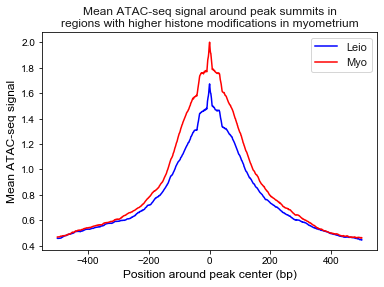

In [14]:
l1, = plt.plot([i for i in range(-500,501)], L_M_ATAC_pileup_mean, c=(0,0,1,1))
l2, = plt.plot([i for i in range(-500,501)], M_M_ATAC_pileup_mean, c=(1,0,0,1))

plt.legend([l1, l2], ["Leio", "Myo"], fontsize=11)

plt.ylabel('Mean ATAC-seq signal', fontsize=12)
plt.xlabel('Position around peak center (bp)', fontsize=12)

plt.title('Mean ATAC-seq signal around peak summits in\nregions with higher histone modifications in myometrium', fontsize=12)

In [15]:
print(L_M_ATAC_pileup_mean[0], L_M_ATAC_pileup_mean[-1])
print(M_M_ATAC_pileup_mean[0], M_M_ATAC_pileup_mean[-1])

0.45885004712936645 0.44562061055556884
0.4682820954286295 0.4609446231324041


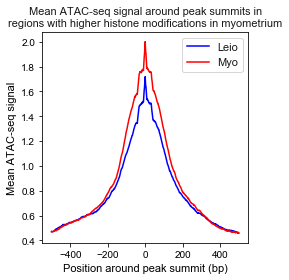

In [16]:
# Figure S7B
fig = plt.figure(figsize=(4,4))

l1, = plt.plot([i for i in range(-500,501)], L_M_ATAC_pileup_mean*((M_M_ATAC_pileup_mean[0] + M_M_ATAC_pileup_mean[-1])/(L_M_ATAC_pileup_mean[0] + L_M_ATAC_pileup_mean[-1])), c=(0,0,1,1))
l2, = plt.plot([i for i in range(-500,501)], M_M_ATAC_pileup_mean, c=(1,0,0,1))

plt.legend([l1, l2], ["Leio", "Myo"], fontsize=11)

plt.ylabel('Mean ATAC-seq signal', fontsize=11)
plt.xlabel('Position around peak summit (bp)', fontsize=11)

plt.title('Mean ATAC-seq signal around peak summits in\nregions with higher histone modifications in myometrium', fontsize=11)

plt.tight_layout()
plt.savefig(output_dir + 'figures/' + 'figureS7_panels/' + file_prefix +
          '_panelB_ATACseq_myo_dist_' + date + '.pdf', format='pdf', transparent=True)